In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
import statsmodels.api as sm

import os
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_absolute_error
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime as dt

In [2]:
# Load all fire detection data
file_path = f"C:/Users/308ca/Desktop/Graduate_Fall24_Courses/CLIMATE588_Regional_Climate_Scale/588_final/Fire_Detections_w_Landcover/all_fire_detections_2009-2019.csv"
all_fire_detections = pd.read_csv(file_path)
all_fire_detections

,OBJECTID,latitude,longitude,acq_date,month,year,LandCoverValue,LandCoverType,LandCoverValueID,Daily Average RH %,NDVI Value,Daily Fire Detections
0,1,36.64200,-94.56720,2009-09-27,9,2009,141,Deciduous Forest,1.0,33.700527,0.330,1
1,2,36.64500,-94.55110,2009-09-27,9,2009,141,Deciduous Forest,2.0,33.700527,0.330,1
2,3,36.64000,-94.57000,2009-09-29,9,2009,141,Deciduous Forest,3.0,32.991512,0.325,1
3,4,36.58560,-93.80030,2009-09-30,9,2009,141,Deciduous Forest,4.0,33.083435,0.330,1
4,5,36.58400,-93.81380,2009-09-30,9,2009,141,Deciduous Forest,5.0,33.083435,0.330,1
...,...,...,...,...,...,...,...,...,...,...,...,...
192008,31561,48.85832,-94.89249,2018-08-22,8,2018,176,Grassland/Pasture,NaN,34.419964,0.431,1
192009,31562,48.85843,-95.25021,2018-10-23,10,2018,190,Woody Wetlands,NaN,33.274350,0.321,1
192010,31563,48.61067,-94.64634,2018-05-12,5,2018,195,Herbaceous Wetlands,NaN,32.885815,0.201,1
192011,31564,48.72762,-94.61402,2018-05-23,5,2018,195,Herbaceous Wetlands,NaN,32.939613,0.329,1


In [3]:
# Aggregate the data by year, including additional metrics
yearly_detections = all_fire_detections.groupby('year').agg({
    'Daily Fire Detections': 'sum',
    'LandCoverType': 'first',  # Assuming we want the first occurrence
    'LandCoverValue': 'first',
    'NDVI Value': 'mean',             # Average NDVI for the year
    'Daily Average RH %': 'mean'  # Average humidity for the year
}).reset_index().rename(columns={
    'Daily Fire Detections': 'Total Yearly Fire Detections',
    'NDVI Value': 'Average Yearly NDVI',
    'Daily Average RH %': 'Average Yearly RH %'
})

# Aggregate the data by month, including additional metrics
monthly_detections = all_fire_detections.groupby('month').agg({
    'Daily Fire Detections': 'sum',
    'LandCoverType': 'first',  # Assuming we want the first occurrence
    'LandCoverValue': 'first',
    'NDVI Value': 'mean',             # Average NDVI for the month
    'Daily Average RH %': 'mean'  # Average humidity for the month
}).reset_index().rename(columns={
    'Daily Fire Detections': 'Total Monthly Fire Detections',
    'NDVI Value': 'Average Monthly NDVI',
    'Daily Average RH %': 'Average Monthly RH %'
})

# Aggregate the data by month and year, including additional metrics
detections_by_month_year = all_fire_detections.groupby(['month', 'year']).agg({
    'Daily Fire Detections': 'sum',
    'LandCoverValue': 'first',
    'LandCoverType': 'first',  # Assuming we want the first occurrence
    'NDVI Value': 'mean',             # Average NDVI for the month and year
    'Daily Average RH %': 'mean'  # Average humidity for the month and year
}).reset_index().rename(columns={
    'Daily Fire Detections': 'Total Monthly Fire Detections',
    'NDVI Value': 'Average Monthly NDVI',
    'Daily Average RH %': 'Average Monthly RH %'
})

monthly_detections

,month,Total Monthly Fire Detections,LandCoverType,LandCoverValue,Average Monthly NDVI,Average Monthly RH %
0,5,39604,Soybeans,5,0.270865,32.518390
1,6,22182,Deciduous Forest,141,0.377821,34.645390
2,7,27159,Soybeans,5,0.426262,35.158197
3,8,30191,Corn,1,0.413343,34.333142
4,9,34693,Deciduous Forest,141,0.355278,33.167483
5,10,38184,Grassland/Pasture,176,0.259212,32.943010


ADF Statistic for 1st Order Differencing (Monthly Aggregated)
ADF Statistic: -28.965003
p-value: 0.000000
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
ADF Statistic for 1st Order Differencing (Yearly Aggregated)
ADF Statistic: -2.277070
p-value: 0.179470
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
ADF Statistic for 1st Order Differencing (Monthly and Yearly Aggregated)
ADF Statistic: -3.303319
p-value: 0.014731
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


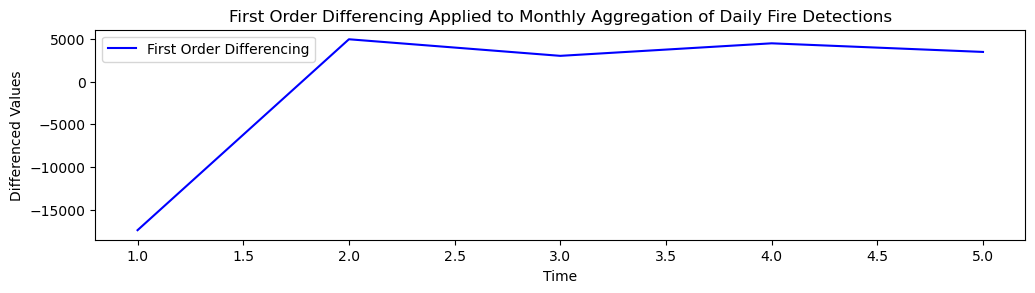

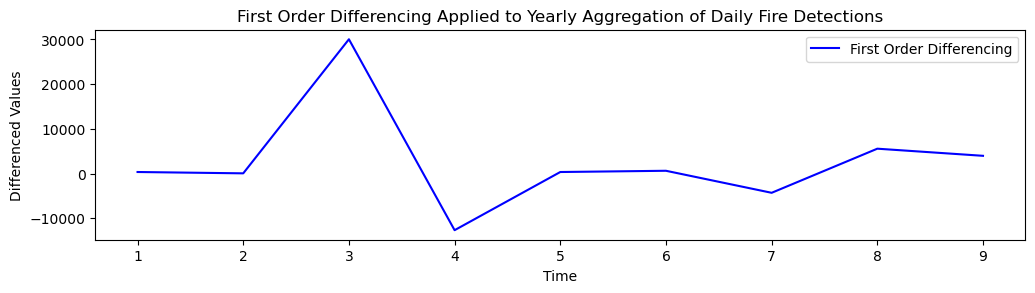

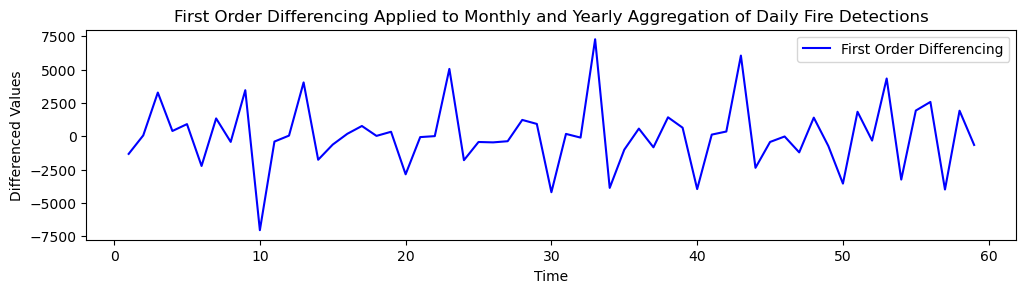

In [4]:
# First order differencing of Daily Fire Detections in monthly_detections, yearly_detections, and detections_by_month_year dataframes
# This will determine the integrated "I" term in Arima

# First Order Differencing
monthly_detections['First Order Differencing'] = monthly_detections['Total Monthly Fire Detections'].diff()
yearly_detections['First Order Differencing'] = yearly_detections['Total Yearly Fire Detections'].diff()
detections_by_month_year['First Order Differencing'] = detections_by_month_year['Total Monthly Fire Detections'].diff()

# ADF Test for First Order Differencing of monthly aggregated daily fire detections.
print('ADF Statistic for 1st Order Differencing (Monthly Aggregated)')
result_monthly = adfuller(monthly_detections['First Order Differencing'].dropna())
print('ADF Statistic: %f' % result_monthly[0])
print('p-value: %f' % result_monthly[1])
print('Critical Values:')
for key, value in result_monthly[4].items():
    print('\t%s: %.3f' % (key, value))

# ADF Test for First Order Differencing of yearly aggregated daily fire detections.
print('ADF Statistic for 1st Order Differencing (Yearly Aggregated)')
result_yearly = adfuller(yearly_detections['First Order Differencing'].dropna())
print('ADF Statistic: %f' % result_yearly[0])
print('p-value: %f' % result_yearly[1])
print('Critical Values:')
for key, value in result_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# ADF Test for First Order Differencing of monthly and yearly aggregated daily fire detections.
print('ADF Statistic for 1st Order Differencing (Monthly and Yearly Aggregated)')
result_monthly_yearly = adfuller(detections_by_month_year['First Order Differencing'].dropna())
print('ADF Statistic: %f' % result_monthly_yearly[0])
print('p-value: %f' % result_monthly_yearly[1])
print('Critical Values:')
for key, value in result_monthly_yearly[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Plotting First Order Differencing for monthly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(monthly_detections['First Order Differencing'], label='First Order Differencing', color='blue')
plt.title('First Order Differencing Applied to Monthly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

# Plotting First Order Differencing for yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(yearly_detections['First Order Differencing'], label='First Order Differencing', color='blue')
plt.title('First Order Differencing Applied to Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

# Plotting First Order Differencing for monthly and yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(detections_by_month_year['First Order Differencing'], label='First Order Differencing', color='blue')
plt.title('First Order Differencing Applied to Monthly and Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

ADF Statistic for 2nd Order Differencing (Yearly Aggregated)
ADF Statistic: -1.060789
p-value: 0.730453
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
ADF Statistic for 2nd Order Differencing (Monthly and Yearly Aggregated)
ADF Statistic: -5.624716
p-value: 0.000001
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


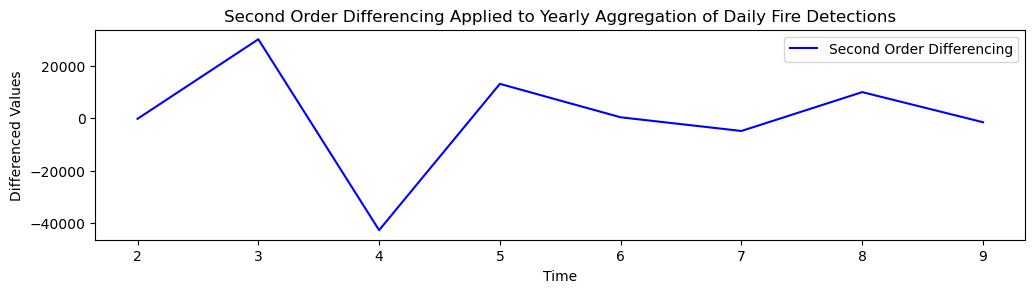

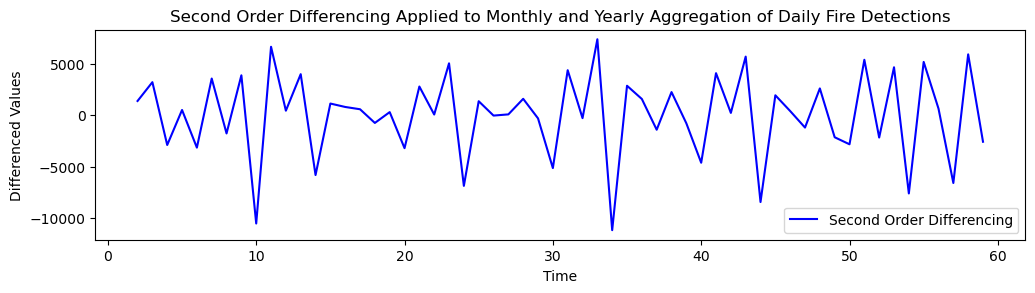

In [5]:
# Second order differencing applied to yearly and monthly/yearly aggregated fire detection data.
# Second Order Differencing
yearly_detections['Second Order Differencing'] = yearly_detections['Total Yearly Fire Detections'].diff().diff()
detections_by_month_year['Second Order Differencing'] = detections_by_month_year['Total Monthly Fire Detections'].diff().diff()

# ADF Test for Second Order Differencing of yearly aggregated daily fire detections.
print('ADF Statistic for 2nd Order Differencing (Yearly Aggregated)')
result_yearly = adfuller(yearly_detections['Second Order Differencing'].dropna())
print('ADF Statistic: %f' % result_yearly[0])
print('p-value: %f' % result_yearly[1])
print('Critical Values:')
for key, value in result_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# ADF Test for Second Order Differencing of monthly and yearly aggregated daily fire detections.
print('ADF Statistic for 2nd Order Differencing (Monthly and Yearly Aggregated)')
result_monthly_yearly = adfuller(detections_by_month_year['Second Order Differencing'].dropna())
print('ADF Statistic: %f' % result_monthly_yearly[0])
print('p-value: %f' % result_monthly_yearly[1])
print('Critical Values:')
for key, value in result_monthly_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# Plotting Second Order Differencing for yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(yearly_detections['Second Order Differencing'], label='Second Order Differencing', color='blue')
plt.title('Second Order Differencing Applied to Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

# Plotting Second Order Differencing for monthly and yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(detections_by_month_year['Second Order Differencing'], label='Second Order Differencing', color='blue')
plt.title('Second Order Differencing Applied to Monthly and Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

ADF Statistic for 3rd Order Differencing (Yearly Aggregated)
ADF Statistic: -18.132729
p-value: 0.000000
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987


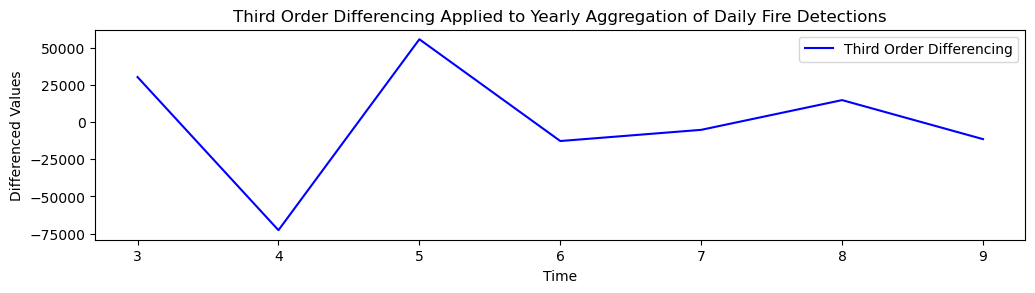

In [6]:
# Third Order Differencing
yearly_detections['Third Order Differencing'] = yearly_detections['Total Yearly Fire Detections'].diff().diff().diff()

# ADF Test for Second Order Differencing of yearly aggregated daily fire detections.
print('ADF Statistic for 3rd Order Differencing (Yearly Aggregated)')
result_yearly = adfuller(yearly_detections['Third Order Differencing'].dropna())
print('ADF Statistic: %f' % result_yearly[0])
print('p-value: %f' % result_yearly[1])
print('Critical Values:')
for key, value in result_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# Plotting Third Order Differencing for yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(yearly_detections['Third Order Differencing'], label='Third Order Differencing', color='blue')
plt.title('Third Order Differencing Applied to Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

In [7]:
#yearly_detections = yearly_detections.drop(columns=['First Order Differencing', 'Second Order Differencing'])
#detections_by_month_year = detections_by_month_year.drop(columns=['First Order Differencing'])

In [8]:
monthly_detections

,month,Total Monthly Fire Detections,LandCoverType,LandCoverValue,Average Monthly NDVI,Average Monthly RH %,First Order Differencing
0,5,39604,Soybeans,5,0.270865,32.518390,NaN
1,6,22182,Deciduous Forest,141,0.377821,34.645390,-17422.0
2,7,27159,Soybeans,5,0.426262,35.158197,4977.0
3,8,30191,Corn,1,0.413343,34.333142,3032.0
4,9,34693,Deciduous Forest,141,0.355278,33.167483,4502.0
5,10,38184,Grassland/Pasture,176,0.259212,32.943010,3491.0


In [9]:
monthly_detections.dropna(inplace=True)
yearly_detections.dropna(inplace=True)
detections_by_month_year.dropna(inplace=True)

# Convert columns to numeric
monthly_detections['Average Monthly NDVI'] = pd.to_numeric(monthly_detections['Average Monthly NDVI'], errors='coerce')
monthly_detections['Average Monthly RH %'] = pd.to_numeric(monthly_detections['Average Monthly RH %'], errors='coerce')
monthly_detections['Total Monthly Fire Detections'] = pd.to_numeric(monthly_detections['Total Monthly Fire Detections'], errors='coerce')
monthly_detections['LandCoverValue'] = pd.to_numeric(monthly_detections['LandCoverValue'], errors='coerce')
yearly_detections['Average Yearly NDVI'] = pd.to_numeric(yearly_detections['Average Yearly NDVI'], errors='coerce')
yearly_detections['Average Yearly RH %'] = pd.to_numeric(yearly_detections['Average Yearly RH %'], errors='coerce')
yearly_detections['Total Yearly Fire Detections'] = pd.to_numeric(yearly_detections['Total Yearly Fire Detections'], errors='coerce')
yearly_detections['LandCoverValue'] = pd.to_numeric(yearly_detections['LandCoverValue'], errors='coerce')
detections_by_month_year['Average Monthly NDVI'] = pd.to_numeric(detections_by_month_year['Average Monthly NDVI'], errors='coerce')
detections_by_month_year['Average Monthly RH %'] = pd.to_numeric(detections_by_month_year['Average Monthly RH %'], errors='coerce')
detections_by_month_year['Total Monthly Fire Detections'] = pd.to_numeric(detections_by_month_year['Total Monthly Fire Detections'], errors='coerce')
detections_by_month_year['LandCoverValue'] = pd.to_numeric(detections_by_month_year['LandCoverValue'], errors='coerce')

In [10]:
monthly_detections

,month,Total Monthly Fire Detections,LandCoverType,LandCoverValue,Average Monthly NDVI,Average Monthly RH %,First Order Differencing
1,6,22182,Deciduous Forest,141,0.377821,34.645390,-17422.0
2,7,27159,Soybeans,5,0.426262,35.158197,4977.0
3,8,30191,Corn,1,0.413343,34.333142,3032.0
4,9,34693,Deciduous Forest,141,0.355278,33.167483,4502.0
5,10,38184,Grassland/Pasture,176,0.259212,32.943010,3491.0


In [11]:
"""The implementation of the ARIMA model for all time-series aggregated datasets utilizes a walk-forward validation method."""

'The implementation of the ARIMA model for all time-series aggregated datasets utilizes a walk-forward validation method.'

In [12]:
"""This is a time-series validation technique where the temporal order of the forecast is preserved, unlike with cross-validation.  At each iteration the training set is divided into a train and test set as long as the test set is always following the training set."""

'This is a time-series validation technique where the temporal order of the forecast is preserved, unlike with cross-validation.  At each iteration the training set is divided into a train and test set as long as the test set is always following the training set.'

In [13]:
"""The best time-series aggregated, stationary dataset to use for model forecasting is determined through error analysis.  Then the dynamic model method will be switched to a static method to see if the optimal model to use changes.  Static models are time invariant regression models and assumes parameters associated with certain predictors are fixed with time. """

'The best time-series aggregated, stationary dataset to use for model forecasting is determined through error analysis.  Then the dynamic model method will be switched to a static method to see if the optimal model to use changes.  Static models are time invariant regression models and assumes parameters associated with certain predictors are fixed with time. '

In [14]:
# ARIMA with walk-forward for monthly and yearly detections
series = detections_by_month_year['Second Order Differencing']

# Split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = list(train)
predictions = []

# Walk-forward method
for t in range(len(test)):
    model = ARIMA(history, order=(0, 2, 0)) 
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Mean Absolute Percentage Error: %.2f%%' % mape)
print('Test RMSE for Monthly and Yearly: %.3f' % rmse)

Mean Absolute Percentage Error: 842.33%
Test RMSE for Monthly and Yearly: 14671.846


In [15]:
"""The combined monthly and yearly aggregated dataframe had to be differenced twice to become nearest to stationary as possible. This results in a Mean Absolute Percentage Error (MAPE) of 842.33% and a Root Mean Square Error score of 14671.846 when implementing ARIMA(0,2,0). """

'The combined monthly and yearly aggregated dataframe had to be differenced twice to become nearest to stationary as possible. This results in a Mean Absolute Percentage Error (MAPE) of 842.33% and a Root Mean Square Error score of 14671.846 when implementing ARIMA(0,2,0). '

In [16]:
"""If we drop to first order differencing, ARIMA(0,1,0), which is the simple Random Walk special case of the ARIMA model, then the MAPE drops to 481.24% and the RMSE drops to 4423.170."""

'If we drop to first order differencing, ARIMA(0,1,0), which is the simple Random Walk special case of the ARIMA model, then the MAPE drops to 481.24% and the RMSE drops to 4423.170.'

In [17]:
"""This dataset was considered to not be autocorrelated when looking at the ACF plots for higher order differencing, but applying a Durbin-Watson test (even though not best meant for higher order differencing) does result in a statistic just under 2 at 1.69, indicating possibly missed positive autocorrelation.  Thus, an added MA term is applied to see if autocorrelation was previously misinterpreted as nonexistent."""

'This dataset was considered to not be autocorrelated when looking at the ACF plots for higher order differencing, but applying a Durbin-Watson test (even though not best meant for higher order differencing) does result in a statistic just under 2 at 1.69, indicating possibly missed positive autocorrelation.  Thus, an added MA term is applied to see if autocorrelation was previously misinterpreted as nonexistent.'

In [18]:
"""Now considering ARIMA(0,1,1), which is again an exponential smoothing of the Random Walk method to account for autocorrelation error, then the MAPE further lessens to 122.2% and the RMSE to 2657.964.  An added MA term has further lessened the MAPE and RMSE of first order differenced monthly and yearly data."""

'Now considering ARIMA(0,1,1), which is again an exponential smoothing of the Random Walk method to account for autocorrelation error, then the MAPE further lessens to 122.2% and the RMSE to 2657.964.  An added MA term has further lessened the MAPE and RMSE of first order differenced monthly and yearly data.'

In [19]:
"""Although a general practice of adding an AR term to positively autocorrelated stationary data was advised by a Duke statistical forecasting page, this actually increased the MAPE to 633.86% and RMSE to 3452.036 with ARIMA(1,1,0) (Fuqua School of Business, n.d.)."""

'Although a general practice of adding an AR term to positively autocorrelated stationary data was advised by a Duke statistical forecasting page, this actually increased the MAPE to 633.86% and RMSE to 3452.036 with ARIMA(1,1,0) (Fuqua School of Business, n.d.).'

In [20]:
# Repeat for yearly_detections
series = yearly_detections['First Order Differencing']

# Split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = list(train)
predictions = []

# Walk-forward method
for t in range(len(test)):
    model = ARIMA(history, order=(0, 1, 0)) 
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Mean Absolute Percentage Error: %.2f%%' % mape)
print('Test RMSE for Yearly: %.3f' % rmse)

# plot forecasts against actual outcomes
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()

Mean Absolute Percentage Error: 110.72%
Test RMSE for Yearly: 6435.568


In [21]:
"""The MAPE for third order differenced yearly fire detections data, ARIMA(0,3,0), is 2060.83% and the RMSE is 165281.946. Transitionaing to first order differencing again results in a MAPE of 110.72% and a RMSE of 6435.568 from ARIMA(0,1,0), the special Random Walk model case."""

'The MAPE for third order differenced yearly fire detections data, ARIMA(0,3,0), is 2060.83% and the RMSE is 165281.946. Transitionaing to first order differencing again results in a MAPE of 110.72% and a RMSE of 6435.568 from ARIMA(0,1,0), the special Random Walk model case.'

In [22]:
"""An issue of dataset size arises when computing ARIMA model RMSE and MAPE due to dataset size."""

'An issue of dataset size arises when computing ARIMA model RMSE and MAPE due to dataset size.'

In [23]:
# Complete an ARIMA model for monthly_detections dataframe by using ARIMA
# evaluate an ARIMA model using a walk-forward validation
# Define the series variable
series = monthly_detections['Total Monthly Fire Detections']

# Split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = list(train)
predictions = []

# Walk-forward method
for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 0))  # Changed to ARIMA(0,1,0)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Mean Absolute Percentage Error: %.2f%%' % mape)
print('Test RMSE for Monthly: %.3f' % rmse)

predicted=32155.817914, expected=34693.000000
predicted=36305.472053, expected=38184.000000
Mean Absolute Percentage Error: 6.12%
Test RMSE for Monthly: 2232.281


In [24]:
"""From ARIMA model MAPE and RMSE inspection, utilizing the monthly aggregated fire detection data that was differenced by one order to become stationary is the most promising time-series aggregated dataset for ARIMA forecasting."""

'From ARIMA model MAPE and RMSE inspection, utilizing the monthly aggregated fire detection data that was differenced by one order to become stationary is the most promising time-series aggregated dataset for ARIMA forecasting.'

In [25]:
"""Although its ARIMA(0,1,0) Random Walk model had a MAPE of 30% and a RMSE of 1261.551, we can account for possible negative correlation in the data from the earlier Durbin-Watson test with ARIMA(1,1,0). This favorably results in a MAPE of 11.26% and a RMSE of 440.727, the lowest error percentage and score of out all the other time-series aggregated detection dataset dynamic ARIMA models completed."""

'Although its ARIMA(0,1,0) Random Walk model had a MAPE of 30% and a RMSE of 1261.551, we can account for possible negative correlation in the data from the earlier Durbin-Watson test with ARIMA(1,1,0). This favorably results in a MAPE of 11.26% and a RMSE of 440.727, the lowest error percentage and score of out all the other time-series aggregated detection dataset dynamic ARIMA models completed.'

In [26]:
"""Thus, moving forward, ARIMA forecasting will be done using the monthly aggregated stationary fire detection data and an ARIMA(1,1,0) or a differenced first-order, autoregressive model."""

'Thus, moving forward, ARIMA forecasting will be done using the monthly aggregated stationary fire detection data and an ARIMA(1,1,0) or a differenced first-order, autoregressive model.'

In [27]:
"""ARIMA forecasting shows an underestimation as the rolling forecast predicted values are smaller than the expected values."""

'ARIMA forecasting shows an underestimation as the rolling forecast predicted values are smaller than the expected values.'

In [28]:
# Now try static forecasting instead of walk forward method on detections_by_month_year
# Complete an ARIMA model for monthly_detections dataframe by using ARIMA(1,1,0)
# Define the series variable
series = detections_by_month_year['First Order Differencing']

# Split into train and test sets
X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

# Fit the ARIMA model on the entire training dataset
model = ARIMA(train, order=(0, 1, 1))
model_fit = model.fit()

# Generate static forecast for the length of the test dataset
forecast = model_fit.forecast(steps=len(test))

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, forecast))
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print results
print('Mean Absolute Percentage Error: %.2f%%' % mape)
print('Test RMSE for Monthly and Yearly: %.3f' % rmse)

Mean Absolute Percentage Error: 98.09%
Test RMSE for Monthly and Yearly: 2608.983


In [29]:
"""For monthly and yearly combined detection data, using an exponential smoothing model of ARIMA(0,1,1) is optimal with a least MAPE of 98.09% and RMSE of 2608.983.  Again showing previous autocorrelation error was missed."""

'For monthly and yearly combined detection data, using an exponential smoothing model of ARIMA(0,1,1) is optimal with a least MAPE of 98.09% and RMSE of 2608.983.  Again showing previous autocorrelation error was missed.'

In [30]:
# Now for yearly static ARIMA model
series = yearly_detections['Third Order Differencing']

# Split into train and test sets
X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

# Fit the ARIMA model on the entire training dataset
model = ARIMA(train, order=(0, 1, 0))
model_fit = model.fit()

# Generate static forecast for the length of the test dataset
forecast = model_fit.forecast(steps=len(test))

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, forecast))
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print results
print('Mean Absolute Percentage Error: %.2f%%' % mape)
print('Test RMSE for Yearly: %.3f' % rmse)

Mean Absolute Percentage Error: 113.91%
Test RMSE for Yearly: 16496.565


In [31]:
"""The ARIMA model with the least error percentage and score for yearly aggregated detection data ends up being a random walk again with a MAPE of 113.91% and RMSE of 16496.565."""

'The ARIMA model with the least error percentage and score for yearly aggregated detection data ends up being a random walk again with a MAPE of 113.91% and RMSE of 16496.565.'

In [32]:
# Now for monthly static ARIMA model
series = monthly_detections['First Order Differencing']

# Split into train and test sets
X = series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]

# Fit the ARIMA model on the entire training dataset
model = ARIMA(train, order=(1, 1, 0))
model_fit = model.fit()

# Generate static forecast for the length of the test dataset
forecast = model_fit.forecast(steps=len(test))

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, forecast))
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Print results
print('Mean Absolute Percentage Error: %.2f%%' % mape)
print('Test RMSE for Monthly: %.3f' % rmse)

Mean Absolute Percentage Error: 5.03%
Test RMSE for Monthly: 298.659


In [33]:
"""The already optimal monthly aggregated data from the dynamically validated ARIMA model is also the most optimal for static modeling.  There are much more optimal error scores for the same ARIMA(1,1,0) of 5.03% for the MAPE and 298.659 for RMSE. """

'The already optimal monthly aggregated data from the dynamically validated ARIMA model is also the most optimal for static modeling.  There are much more optimal error scores for the same ARIMA(1,1,0) of 5.03% for the MAPE and 298.659 for RMSE. '

In [34]:
"""Since the static and dynamic ARIMA models for the stationary and first order differenced monthly detection data are optimal by error analysis, predictioins with these models are optimal for forecasting methods.  The difference being whether dynamic or static forecasting are preffered for fire detection analysis going forward."""

'Since the static and dynamic ARIMA models for the stationary and first order differenced monthly detection data are optimal by error analysis, predictioins with these models are optimal for forecasting methods.  The difference being whether dynamic or static forecasting are preffered for fire detection analysis going forward.'

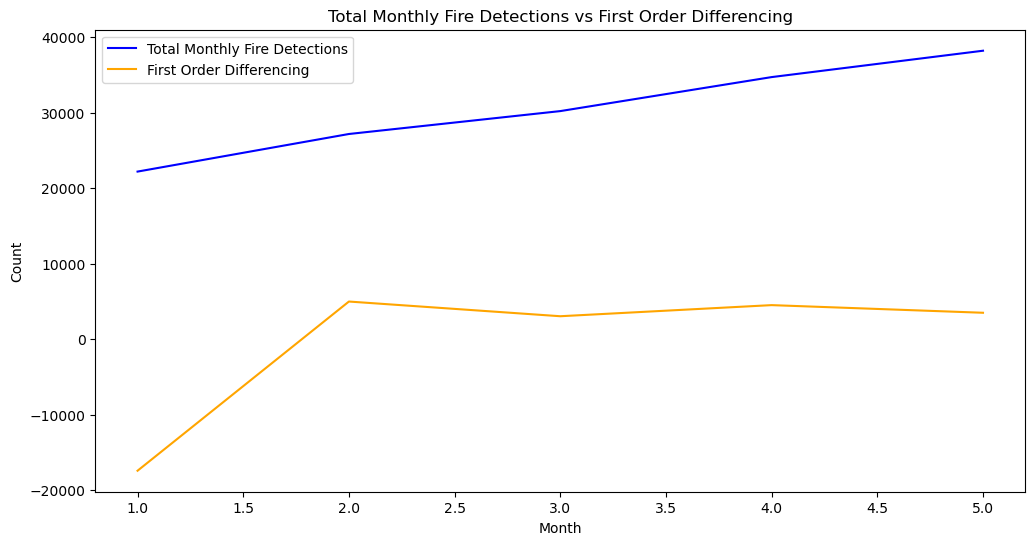

In [35]:
# Create plot of Total Monthly Fire Detections and First Order Differencing columns per month column 
plt.figure(figsize=(12, 6))
plt.plot(monthly_detections['Total Monthly Fire Detections'], label='Total Monthly Fire Detections', color='blue')
plt.plot(monthly_detections['First Order Differencing'], label='First Order Differencing', color='orange')
plt.title('Total Monthly Fire Detections vs First Order Differencing')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.show()

In [36]:
"""Adding seasonal term to make forecasts"""

'Adding seasonal term to make forecasts'

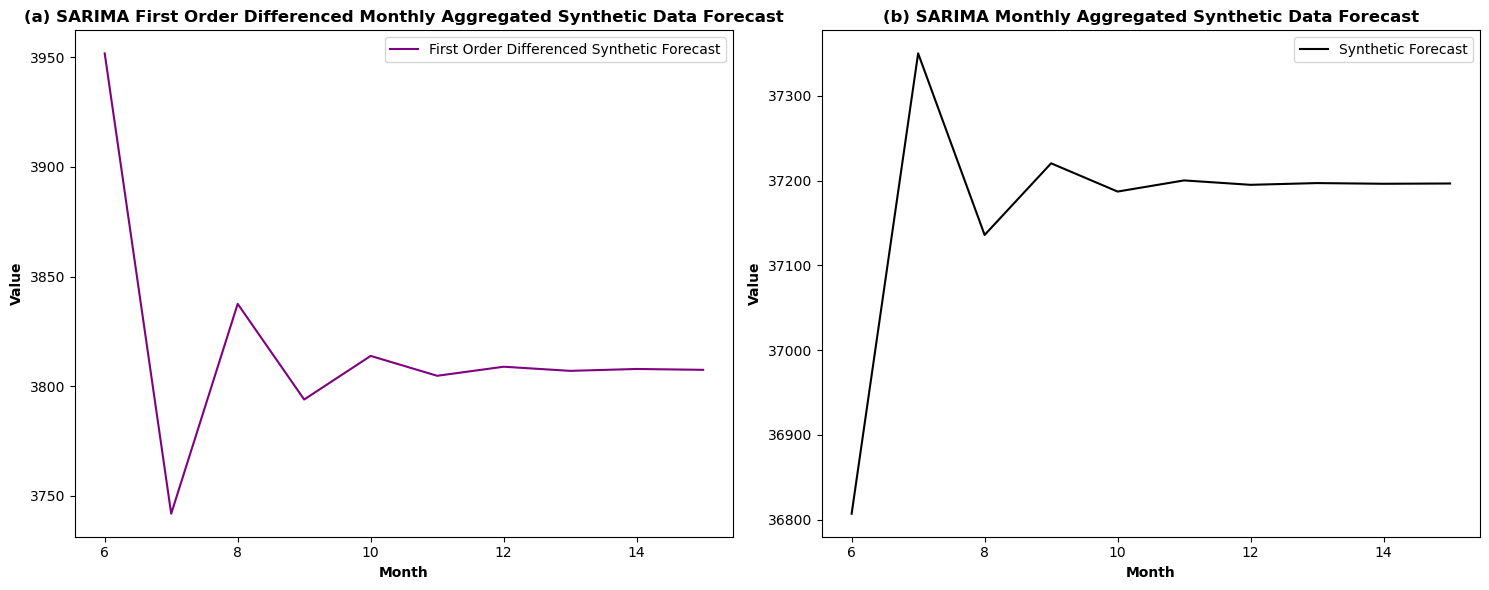

In [39]:
# Load all fire detection data
file_path = f"C:/Users/308ca/Desktop/Graduate_Fall24_Courses/CLIMATE588_Regional_Climate_Scale/588_final/Fire_Detections_w_Landcover/all_fire_detections_2009-2019.csv"
all_fire_detections = pd.read_csv(file_path)
all_fire_detections

# Aggregate the data by month, including additional metrics
monthly_detections = all_fire_detections.groupby('month').agg({
    'Daily Fire Detections': 'sum',
    'LandCoverType': 'first',  # Assuming we want the first occurrence
    'LandCoverValue': 'first',
    'NDVI Value': 'mean',             # Average NDVI for the month
    'Daily Average RH %': 'mean'  # Average humidity for the month
}).reset_index().rename(columns={
    'Daily Fire Detections': 'Total Monthly Fire Detections',
    'NDVI Value': 'Average Monthly NDVI',
    'Daily Average RH %': 'Average Monthly RH %'
})

# Create synthetic data from Total Monthly Fire Detections in monthly_detections dataframe column
# Adding random noise to simulate synthetic data
np.random.seed(42)  # For reproducibility
#noise = np.random.normal(0, 50, size=len(monthly_detections))
# Apply first order differencing to achieve stationarity
monthly_detections['First Order Differencing'] = monthly_detections['Total Monthly Fire Detections'].diff()
synthetic_data = monthly_detections['First Order Differencing'] #+ noise
synthetic_data2 = monthly_detections['Total Monthly Fire Detections']

# Create a DataFrame for synthetic data
df = pd.DataFrame({
    'Date': monthly_detections['month'],
    'Differenced Synthetic Value': synthetic_data,
    'Synthetic Value': synthetic_data2
})

# Save the data to CSV
df.to_csv('synthetic_time_series_data.csv')

# Load the differenced synthetic data
data = pd.read_csv('synthetic_time_series_data.csv')
series = data['Differenced Synthetic Value']
# Fit SARIMA model
model = SARIMAX(series, order=(1, 1, 0), seasonal_order=(0, 0, 0, 12))
model_fit = model.fit()
# Forecast future values
forecast = model_fit.forecast(steps=10)
  
# Load the non-differenced synthetic data
data = pd.read_csv('synthetic_time_series_data.csv')
series2 = data['Synthetic Value']
# Fit SARIMA model
model2 = SARIMAX(series2, order=(1, 1, 0), seasonal_order=(0, 0, 0, 12)) # assume seasonal affects repeat every twelve months due to harvest seasons occuring each year
model_fit2 = model2.fit()
# Forecast future values
forecast2 = model_fit2.forecast(steps=10)

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first order differenced synthetic forecast
axs[0].plot(forecast, label='First Order Differenced Synthetic Forecast', color='purple')
axs[0].set_title('(a) SARIMA First Order Differenced Monthly Aggregated Synthetic Data Forecast', fontweight='bold')
axs[0].set_xlabel('Month', fontweight='bold')
axs[0].set_ylabel('Value', fontweight='bold')
axs[0].legend()

# Plot the synthetic forecast
axs[1].plot(forecast2, label='Synthetic Forecast', color='black')
axs[1].set_title('(b) SARIMA Monthly Aggregated Synthetic Data Forecast', fontweight='bold')
axs[1].set_xlabel('Month', fontweight='bold')
axs[1].set_ylabel('Value', fontweight='bold')
axs[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


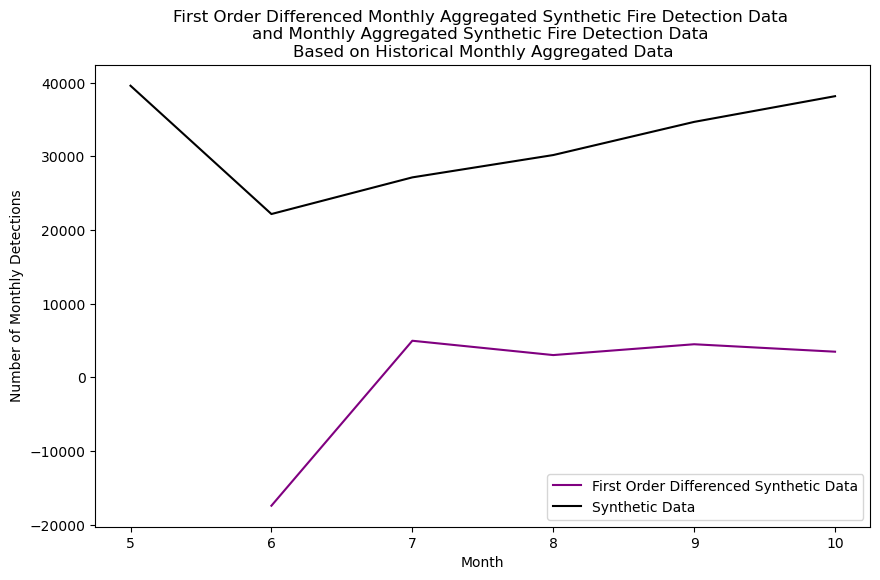

In [40]:
# Plot synthetic data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Differenced Synthetic Value'], label='First Order Differenced Synthetic Data', color='purple')
plt.plot(df['Date'], df['Synthetic Value'], label='Synthetic Data',  color='black')
plt.title('First Order Differenced Monthly Aggregated Synthetic Fire Detection Data \nand Monthly Aggregated Synthetic Fire Detection Data \nBased on Historical Monthly Aggregated Data')
plt.xlabel('Month')
plt.ylabel('Number of Monthly Detections')
plt.legend()
plt.show()